In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import numba
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from filer3 import Filer
%matplotlib inline

#importing the required ML packages
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [2]:
df_S1 = pd.read_csv('train_S1.csv')
df_S2 = pd.read_csv('train_S2.csv')
df_S3 = pd.read_csv('train_S3.csv')

#### これからやることリスト
##### A. 説明変数の再設計
-A.4. 雲量を表すパラメータの追加（前日の同時刻での全天日射量/大気外日射量の追加or調べる時刻における全天日射量/大気外日射量の予測値の追加）<br>
-A.5. 各変数の正規化（Normalized-Temp）<br>
##### B. 予測モデルの追加
 -B.1. 既存のLassoに加えて、K-NNを実施する<br>
-B.2. K-NNのパラメータ調整（正規化、重みづけ最適化、過学習＆過多処理対策としての変数処理）<br>
 -B.2. スコアの伸び率によって、三層パーセプトロンやSVRも検討する<br>

##### A*　Ex-Solar ≒ 0は分けておく

In [3]:
d = df_S1[df_S1['Ex-Solar'] <= 1]
d.groupby('Solar1')['Solar1'].count()

Solar1
0.0     33972
1.0         3
2.0         2
4.0         2
5.0         1
9.0         1
15.0        1
16.0        1
17.0        1
Name: Solar1, dtype: int64

In [4]:
d = df_S3[df_S3['Ex-Solar'] <= 1]
d.groupby('Solar3')['Solar3'].count()

Solar3
0.0     19957
10.0        4
70.0        1
Name: Solar3, dtype: int64

よって、Ex-Solarが1以下なら、Solarは0としてしまってよい。

In [5]:
df_S1_ = df_S1[df_S1['Ex-Solar'] <= 1]
df_S1 = df_S1[df_S1['Ex-Solar'] > 1]
df_S2_ = df_S2[df_S2['Ex-Solar'] <= 1]
df_S2 = df_S2[df_S2['Ex-Solar'] > 1]
df_S3_ = df_S3[df_S3['Ex-Solar'] <= 1]
df_S3 = df_S3[df_S3['Ex-Solar'] > 1]

##### A4　雲量の予測値の追加

上の結果より、「Ex-Solar <= 1」は全て「Solar=0」と予測し、「Ex-Solar > 1」を予測することをこれからの目標とする。<br>
ここで「Ex-Solar > 1」をメインのdfとし、これに雲量に関わりうる　Pre-Clowd：（(全天日射量 / Ex-Solar )の予測値）を加えていく。<br>

In [6]:
#横浜と甲府のデータを見ていく
data = Filer.read_tsv('data/sfc_47670_yokohama.tsv')
df_yoko= pd.DataFrame(data[1:], columns = data[0])
data = Filer.read_tsv('data/sfc_47638_kofu.tsv')
df_kofu= pd.DataFrame(data[1:], columns = data[0])

In [7]:
pd.set_option('display.max_columns', None)
df_kofu.head()

,datetime,pr,f_pr,max_iws,f_max_iws,ave_wv,f_ave_wv,ave_ws,f_ave_ws,max_tp,f_max_tp,min_tp,f_min_tp,sl,f_sl,dsr,f_dsr,gsr,f_gsr,sd,f_sd,dsd,f_dsd,lap,f_lap,sap,f_sap,cap,f_cap,3h_cap,f_3h_cap,rhm,f_rhm,min_rhm,f_min_rhm,vp,f_vp,dtp,f_dtp,vb,f_vb,weather,f_weather
0,201201010010,0,2,13,0,21,0,7,0,20,0,18,0,0,2,,48,0,2,0,2,0,2,9892,0,10242,0,8,0,-1,0,55,0,54,0,39,0,-62,0,,56,,
1,201201010020,0,2,20,0,19,0,10,0,19,0,18,0,0,2,,48,0,2,0,2,0,2,9892,0,10242,0,7,0,-1,0,54,0,54,0,38,0,-65,0,,56,,
2,201201010030,0,2,32,0,22,0,15,0,19,0,17,0,0,2,,48,0,2,0,2,0,2,9892,0,10242,0,7,0,-1,0,53,0,53,0,37,0,-68,0,,56,,
3,201201010040,0,2,21,0,22,0,12,0,18,0,17,0,0,2,,48,0,2,0,2,0,2,9893,0,10243,0,5,0,-2,0,52,0,52,0,36,0,-70,0,,56,,
4,201201010050,0,2,17,0,18,0,11,0,19,0,17,0,0,2,,48,0,2,0,2,0,2,9893,0,10243,0,5,0,-2,0,52,0,52,0,36,0,-69,0,,56,,


In [8]:
df_yoko['f_gsr'] = df_yoko['f_gsr'].map(lambda x: None if x == '' else int(x))
df_yoko['gsr'] = df_yoko['gsr'].map(lambda x: None if x == '' else int(x))
df_kofu['f_gsr'] = df_kofu['f_gsr'].map(lambda x: None if x == '' else int(x))
df_kofu['gsr'] = df_kofu['gsr'].map(lambda x: None if x == '' else int(x))

In [9]:
dfs = [df_yoko, df_kofu]

def MtoD(x, y):
    
    r = 0
    if x >= 2:
        r = r + 31
        
        if x >= 3:
            if y%4 == 0:
                r = r + 29
            else:
                r = r + 28
            
            if x >= 4:
                r = r + 31
                if x >= 5:
                    r = r + 30
                    if x >= 6:
                        r = r + 31
                        if x >= 7:
                            r = r + 30
                            if x >= 8:
                                r = r + 31
                                if x >= 9:
                                    r = r + 31
                                    if x >= 10:
                                        r = r + 30
                                        if x >= 11:
                                            r = r + 31
                                            if x == 12:
                                                r = r + 30
    return r

@numba.jit
def Make_DateNo(M,D,Y):
    Date_No = np.zeros(len(D))
    for i in tqdm(range(len(D))):
        Date_No[i] = MtoD(M[i],Y[i]) + D[i]
    return Date_No

@numba.jit
def C(T):
    ans = np.empty(len(T))
    for i in tqdm(range(len(T))):
        x = T[i]
        if x[2:4] == "00":
            ans[i] = float(x[0:2])
        elif x[2:4] == "10":
            ans[i] = float(x[0:2]) + (1 / 6)
        elif x[2:4] == "20":
            ans[i] = float(x[0:2]) + (2 / 6)
        elif x[2:4] == "30":
            ans[i] = float(x[0:2]) + (3 / 6)
        elif x[2:4] == "40":
            ans[i] = float(x[0:2]) + (4 / 6)
        else:
            ans[i] = float(x[0:2]) + (5 / 6)
    return ans


for df_yoko in dfs:
    df_yoko['Year'] = df_yoko['datetime'].map(lambda x : x[0:4])
    df_yoko['Month'] = df_yoko['datetime'].map(lambda x : x[4:6])
    df_yoko['Date'] = df_yoko['datetime'].map(lambda x : x[6:8])
    df_yoko['Time'] = df_yoko['datetime'].map(lambda x : x[8:12])

    df_yoko['Year'] = df_yoko['Year'].map(lambda x: int(x))
    df_yoko['Month'] = df_yoko['Month'].map(lambda x: int(x))
    df_yoko['Date'] = df_yoko['Date'].map(lambda x: int(x))

    df_yoko['Time'] = C(df_yoko['Time'])
    df_yoko['Time'] = df_yoko['Time'].map(lambda x: round(x,1))

    M = df_yoko['Month']
    D = df_yoko['Date']
    Y = df_yoko['Year']
    df_yoko['Date-No'] = Make_DateNo(M,D,Y)
    df_yoko['Date-No'] = df_yoko['Date-No'].map(lambda x: int(x))

df_kofu = df_kofu.ix[:,['Year', 'Date-No', 'Time', 'f_gsr','gsr']]    
df_yoko = df_yoko.ix[:,['Year', 'Date-No', 'Time', 'f_gsr','gsr']]

100%|██████████| 276048/276048 [00:11<00:00, 23054.15it/s]


In [10]:
#30分間の全天日射量（MJ/(m^2)）をここ30分間の平均値*30で推定
df_yoko['In-Solar'] = (df_yoko['gsr'] + df_yoko['gsr'].shift(1) + df_yoko['gsr'].shift(2) + df_yoko['gsr'].shift(3)) * 450 / (10**5)
df_kofu['In-Solar'] = (df_kofu['gsr'] + df_kofu['gsr'].shift(1) + df_kofu['gsr'].shift(2) + df_kofu['gsr'].shift(3)) * 450 / (10**5)

In [11]:
df_yoko = pd.merge(df_S1, df_yoko, on=['Year', 'Date-No', 'Time'])
df_kofu = pd.merge(df_S3, df_kofu, on=['Year', 'Date-No', 'Time'])

In [12]:
#スケールを揃える為に2倍を加えてRatioを出す
df_yoko['In-Ex-Ratio'] = df_yoko['In-Solar'] / (df_yoko['Ex-Solar'] * 2)
df_kofu['In-Ex-Ratio'] = df_kofu['In-Solar'] /  (df_kofu['Ex-Solar'] * 2)

前日同時刻のEx-Ratio, Rain-Change, Temp-Change, （Weather-Change(Yes or No)）, WC * Sunny, WC* Clowdy, WC * Rainy, WC * Snowyを加える

In [13]:
df_yoko = df_yoko.ix[:, ['In-Ex-Ratio', 'Year', 'Date-No', 'Time', 'Rain', 'Temp', 'Wind', 'Clowdy', 'Rainy', 'Snowy']]
df_kofu = df_kofu.ix[:, ['In-Ex-Ratio', 'Year', 'Date-No', 'Time', 'Rain', 'Temp', 'Wind', 'Clowdy', 'Rainy', 'Snowy']]

In [14]:
@numba.jit
def SearchIndex(Y, D, T):
    Index = np.empty(len(Y))
    for i in tqdm(range(len(Y))):
        j = i
        while (j > i - 40) and (j >= 0) :
            if (Y[j] == Y[i]) and (D[j] + 1 == D[i]) and (T[j] == T[i]):
                Index[i] = j
                break
            else:
                j = j -1
    return Index

In [15]:
df_yoko['Ex-Index'] = SearchIndex(df_yoko['Year'], df_yoko['Date-No'], df_yoko['Time'])
df_kofu['Ex-Index'] = SearchIndex(df_kofu['Year'], df_kofu['Date-No'], df_kofu['Time'])

100%|██████████| 36123/36123 [00:55<00:00, 653.80it/s]


In [16]:
df_yoko['Ex-Index'] = df_yoko['Ex-Index'].fillna('')
df_kofu['Ex-Index'] = df_kofu['Ex-Index'].fillna('')
df_yoko['Ex-Index'] = df_yoko['Ex-Index'].map(lambda x: None if x == '' else int(x))
df_kofu['Ex-Index'] = df_kofu['Ex-Index'].map(lambda x: None if x == '' else int(x))

In [17]:
#前日要素の投入
def A(df):
    
    N = len(df)
    Index = np.array(df['Ex-Index'])
    Ratio = np.array(df['In-Ex-Ratio'])
    Rain = np.array(df['Rain'])
    Temp = np.array(df['Temp'])
    Clowdy = np.array(df['Clowdy'])
    Rainy = np.array(df['Rainy'])
    Snowy = np.array(df['Snowy'])
    
    Ex_Ratio = np.empty(N)
    wc = np.zeros(N)
    s_to_rs = np.zeros(N)
    c_to_rs = np.zeros(N)
    rs_to_s = np.zeros(N)
    c_to_s = np.zeros(N)
    rs_to_c = np.zeros(N)
    s_to_c = np.zeros(N)
    Rain_Change = np.empty(N)
    Temp_Change = np.empty(N)
    
    for i in tqdm(range(N)):
        j = Index[i]
        if j == j:
            Ex_Ratio[i] = Ratio[j]
            Rain_Change[i] = Rain[i] - Rain[j]
            Temp_Change[i] = Temp[i] - Temp[j]
            
            if (Clowdy[i] != Clowdy[j]) or (Rainy[i] != Rainy[j]) or (Snowy[i] != Snowy[j]):
                if (Rainy[i] == 1) or (Snowy[i] == 1):
                    if ((Clowdy[j] == 0) and (Rainy[j] == 0) and (Snowy[j] == 0)):
                        s_to_rs[i] = 1
                    elif Clowdy[j] == 1:
                        c_to_rs[i] = 1
                elif ((Clowdy[i] == 0) and (Rainy[i] == 0) and (Snowy[i] == 0)):
                    if ((Rainy[j] == 1) or (Snowy[j] == 1)):
                        rs_to_s[i] = 1
                    elif Clowdy[j] == 1:
                        c_to_s[i] = 1
                elif Clowdy[i] == 1:
                    if ((Rainy[j] == 1) or (Snowy[j] == 1)):
                        rs_to_c[i] = 1
                    elif ((Clowdy[j] == 0) and (Rainy[j] == 0) and (Snowy[j] == 0)):
                        s_to_c[i] = 1
                        
    df['Ex-Ratio'] = Ex_Ratio
    df['Rain_Change'] = Rain_Change
    df['Temp_Change'] = Temp_Change
    df['s_to_rs'] = s_to_rs
    df['c_to_rs'] = c_to_rs
    df['rs_to_s'] = rs_to_s
    df['rs_to_c'] = rs_to_c
    df['s_to_c'] = s_to_c
    df['c_to_s'] = c_to_s
    
    return df

In [18]:
df_yoko = A(df_yoko)
df_kofu = A(df_kofu)

100%|██████████| 36123/36123 [00:00<00:00, 73137.25it/s]


In [20]:
df_yoko.head()

,In-Ex-Ratio,Year,Date-No,Time,Rain,Temp,Wind,Clowdy,Rainy,Snowy,Ex-Index,Ex-Ratio,Rain_Change,Temp_Change,s_to_rs,c_to_rs,rs_to_s,rs_to_c,s_to_c,c_to_s
0,0.060850,2012,1,7.0,30.0,4,2,1,0,0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.109708,2012,1,7.5,30.0,4,2,1,0,0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.228558,2012,1,8.0,30.0,4,2,1,0,0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.370036,2012,1,8.5,30.0,4,2,1,0,0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.478584,2012,1,9.0,30.0,4,2,1,0,0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
#欠損値の除去、学習用データセットの準備
df_y = df_yoko.ix[:,['In-Ex-Ratio', 'Ex-Ratio', 'Rain_Change', 'Temp_Change', 's_to_c', 's_to_rs', 'c_to_s', 'c_to_rs', 'rs_to_s', 'rs_to_c', 'Ex-Index']]
df_y = df_y.dropna(subset=['Ex-Index', 'In-Ex-Ratio', 'Ex-Ratio'])
df_y = df_y.drop('Ex-Index', axis =1)

df_k = df_kofu.ix[:,['In-Ex-Ratio', 'Ex-Ratio', 'Rain_Change', 'Temp_Change', 's_to_c', 's_to_rs', 'c_to_s', 'c_to_rs', 'rs_to_s', 'rs_to_c',  'Ex-Index']]
df_k = df_k.dropna(subset=['Ex-Index', 'In-Ex-Ratio', 'Ex-Ratio'])
df_k = df_k.drop('Ex-Index', axis =1)

＜これから＞<br>
df_y, df_kで予測して、indexのouterマージでdf_yoko, df_kofuに戻し、df_S1, ... , df_S3にPre-Clowdとして加える

In [34]:
#まずはdf_yで。
df = df_y
df.head()

,In-Ex-Ratio,Ex-Ratio,Rain_Change,Temp_Change,s_to_c,s_to_rs,c_to_s,c_to_rs,rs_to_s,rs_to_c
20,0.062699,0.060850,-10.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.092021,0.109708,-10.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.280155,0.228558,-10.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.469557,0.370036,-10.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.551250,0.478584,-10.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


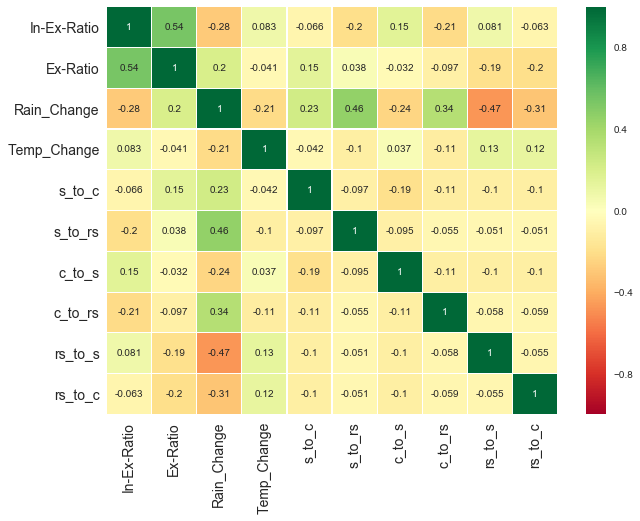

In [33]:
#相関を見る
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(9,7.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### モデルの予測

オプションは、①変数をいじってLasso、②正規化して重みづけをしてK-NN、③とりあえずRF、④よくわからないままSVR（radial, linear）。<br>

とりあえず、目的値はMAE / mu < 0.05。

In [28]:
df['In-Ex-Ratio'].mean()

0.5040224035887821

ゆえ、MAE < 0.025を目指す。

In [27]:
train,test=train_test_split(df,test_size=0.3,random_state=0)
train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]
test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]
X=df[df.columns[1:]]
Y=df['In-Ex-Ratio']

まずはざっくりとやってみる。

In [31]:
#RF
model=RandomForestRegressor(n_estimators=100)
model.fit(train_X,train_Y)
prediction=model.predict(test_X)
print('The MAE of the Random Forests is', metrics.mean_absolute_error(prediction,test_Y))

The MAE of the Random Forests is 0.165792323235


In [39]:
#Lasso
model = linear_model.Lasso(alpha=1.0)
model.fit(train_X,train_Y)
prediction=model.predict(test_X)
print('The MAE of Lasso is', metrics.mean_absolute_error(prediction,test_Y))

The MAE of Lasso is 0.238017443879


In [36]:
#radial SVM
model=svm.SVR(kernel='rbf',C=1,gamma=0.1)
model.fit(train_X,train_Y)
prediction1=model.predict(test_X)
print('The MAE for rbf SVR is ',metrics.mean_absolute_error(prediction1,test_Y))

The MAE for rbf SVR is  0.159933989368


In [37]:
#linear SVM
model=svm.SVR(kernel='linear',C=0.1,gamma=0.1)
model.fit(train_X,train_Y)
prediction2=model.predict(test_X)
print('The MAE for linear SVM is',metrics.mean_absolute_error(prediction2,test_Y))

The MAE for linear SVM is 0.168584603715
